../output/figure1MNIST-20190524-120834.txt
MNIST


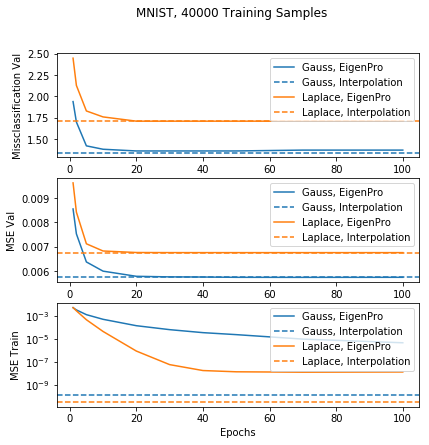

../output/figure1CIPHAR-20190524-125637.txt
CIPHAR


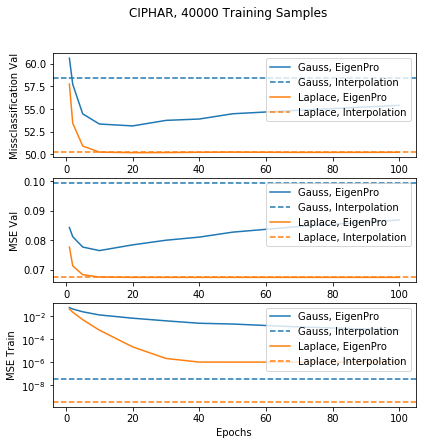

../output/figure1Synthetic1-20190520-130500.txt
Synthetic1


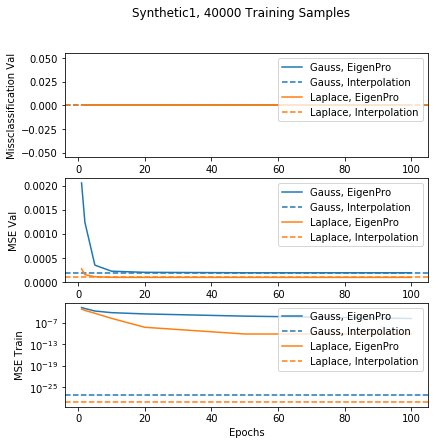

../output/figure1Synthetic2-20190524-133739.txt
Synthetic2


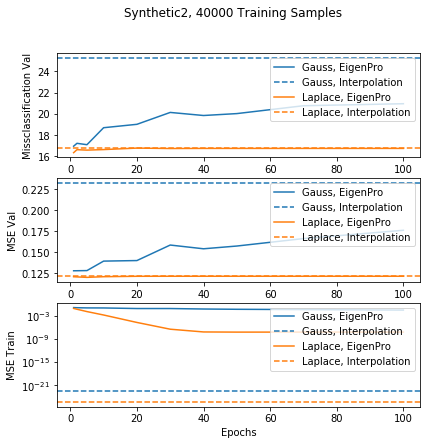

In [7]:

for dataset_name in ['MNIST', 'CIPHAR', 'Synthetic1', 'Synthetic2']:
# for dataset_name in ['CIPHAR']:

    import glob
    files = glob.glob("../output/figure1" + dataset_name + "*.txt")
    files.sort()

    filename = files[-1]
    print(filename)

    trainers_dict = eval(open(filename, 'r').read())
#     trainers_dict

#     trainers_dict = eval("{'Gauss': {'tr_scores': {1: [0.055244683027267455, 0.74516], 2: [0.03720289725899696, 0.87216], 5: [0.019378370054364203, 0.96448], 10: [0.010033366076052189, 0.98692], 20: [0.004832662391811609, 0.9948], 50: [0.001369904287867248, 0.99948], 100: [0.0004349102476099506, 0.99984]}, 'te_scores': {1: [0.08377405388355255, 0.4031], 2: [0.07723868534564972, 0.4319], 5: [0.07573406918048858, 0.446], 10: [0.07675770550966263, 0.4507], 20: [0.0800904596567154, 0.4406], 50: [0.08508943128585815, 0.4303], 100: [0.08925295894145965, 0.4202]}, 'lin_train_mse': 6.552835e-09, 'lin_train_ce': 0.0, 'lin_test_mse': 0.098490156, 'lin_test_ce': 0.6014}, 'Laplace': {'tr_scores': {1: [0.038677211587429046, 0.92192], 2: [0.021250501000881196, 0.99416], 5: [0.004666659050583839, 1.0], 10: [0.0005318473148532212, 1.0], 20: [1.7068692186148836e-05, 1.0], 50: [9.845904935264115e-07, 1.0], 100: [1.0049093974430433e-06, 1.0]}, 'te_scores': {1: [0.07342266005277634, 0.438], 2: [0.07121272395849228, 0.4545], 5: [0.07008565965890884, 0.4666], 10: [0.0696141887664795, 0.4739], 20: [0.06960592057704926, 0.4747], 50: [0.06960942046642303, 0.4744], 100: [0.06960945895910263, 0.4745]}, 'lin_train_mse': 1.6179506e-10, 'lin_train_ce': 0.0, 'lin_test_mse': 0.06960826, 'lin_test_ce': 0.5257}}")



    import matplotlib.pyplot as plt

    print(dataset_name)

    fig, axs = plt.subplots(3)
    ax = plt.gca()
    fig.set_size_inches(6.5, 6.5)
    

    for name, trainer in trainers_dict.items():  

        dic = trainer['te_scores']

        epoch = [x for x in dic.keys()]
        mse   = [x[0] for x in dic.values()]
        miss  = [(1 - x[1]) * 100 for x in dic.values()]

        color = next(ax._get_lines.prop_cycler)['color']
        axs[0].plot(epoch, miss, label=name + ', EigenPro', color=color)      
        axs[0].axhline(y=trainer['lin_test_ce'] * 100, label=name + ', Interpolation', linestyle='--', color=color)

    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Missclassification Val')
    axs[0].legend(loc='upper right')

    ax.set_prop_cycle(None)

    for name, trainer in trainers_dict.items():  

        dic = trainer['te_scores']

        epoch = [x for x in dic.keys()]
        mse   = [x[0] for x in dic.values()]
        miss  = [x[1] for x in dic.values()]

        color = next(ax._get_lines.prop_cycler)['color']
        axs[1].plot(epoch, mse, label=name + ', EigenPro', color=color) 
        axs[1].axhline(y=trainer['lin_test_mse'], label=name + ', Interpolation', linestyle='--', color=color)

    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('MSE Val')
    axs[1].legend(loc='upper right')

    ax.set_prop_cycle(None)

    for name, trainer in trainers_dict.items():  

        dic = trainer['tr_scores']

        epoch = [x for x in dic.keys()]
        mse   = [x[0] for x in dic.values()]
        miss  = [x[1] for x in dic.values()]

        color = next(ax._get_lines.prop_cycler)['color']
        axs[2].plot(epoch, mse, label=name + ', EigenPro', color=color) 
        axs[2].axhline(y=trainer['lin_train_mse'], label=name + ', Interpolation', linestyle='--', color=color)

    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('MSE Train')
    axs[2].set_yscale('log')
    axs[2].legend(loc='upper right')
    
    
    fig.suptitle(dataset_name + ', 40000 Training Samples')

    import matplotlib2tikz
    filename = '../tikz/Figure1_' + dataset_name + '.tex'
    matplotlib2tikz.save(filename)    

    filename = '../png/Figure1_' + dataset_name + '.png'
    plt.savefig(filename)
    plt.show()


In [2]:
#del trainers_dict